In [5]:
%pip install -U sentence-transformers datasets

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# https://huggingface.co/blog/matryoshka

In [ ]:
from datasets import load_dataset
from sentence_transformers import SentenceTransformer, util, cos_sim
import time
import numpy as np

In [58]:
ds = load_dataset('csv', data_files='C://data/medquad.csv')['train'][:5000]


In [60]:
# Embeddings with Base Model
base_model = SentenceTransformer("all-MiniLM-L6-v2")
start_time = time.time()
base_corpus_embeddings = base_model.encode(ds["answer"], convert_to_numpy=True, show_progress_bar=True)
elapsed_time = time.time() - start_time
print(f"Time taken to encode Base corpus: {elapsed_time:.2f} seconds")

print("Base corpus embeddings shape:", base_corpus_embeddings.shape)
print(base_corpus_embeddings)

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Time taken to encode Base corpus: 336.91 seconds
Base corpus embeddings shape: (5000, 384)
[[ 3.03888675e-02 -1.17290542e-01  5.49236946e-02 ...  4.31010574e-02
  -2.71662208e-03  5.00932224e-02]
 [ 7.33746141e-02 -1.95112601e-02  3.68791334e-02 ... -7.11469329e-05
  -8.75142813e-02 -1.34691354e-02]
 [ 2.59362683e-02 -1.06377818e-01  2.76717339e-02 ...  1.75831094e-02
  -1.03403315e-01 -3.16109811e-03]
 ...
 [-7.26920217e-02 -6.02105893e-02 -5.08947410e-02 ... -5.48095116e-03
   6.75078407e-02 -6.28402084e-02]
 [-6.09528907e-02 -3.35598253e-02 -4.13098931e-02 ...  7.10061491e-02
   1.17274590e-01 -8.44397843e-02]
 [-3.79715301e-02  7.10930536e-03 -3.22647728e-02 ... -2.38514114e-02
   1.00491785e-01 -9.15507972e-02]]


In [ ]:
# Embeddings with Matryoshka model
matryoshka_model = SentenceTransformer("tomaarsen/mpnet-base-nli-matryoshka")
start_time = time.time()
matryoshka_corpus_embeddings = matryoshka_model.encode(ds["answer"], convert_to_numpy=True, show_progress_bar=True)
elapsed_time = time.time() - start_time
print(f"Time taken to encode Matryoshka corpus: {elapsed_time:.2f} seconds")
# 40mins 28.8sec


print("Matryoshka corpus embeddings shape:", matryoshka_corpus_embeddings.shape)
print(matryoshka_corpus_embeddings)

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Time taken to encode Matryoshka corpus: 2423.99 seconds
Matryoshka corpus embeddings shape: (5000, 768)
[[-0.00595097 -0.22718419 -0.10382528 ... -0.06697863 -0.00799983
  -0.01083289]
 [-0.11499088 -0.12347724 -0.13602893 ...  0.0079826  -0.00278666
  -0.01050331]
 [-0.12204263 -0.2512605  -0.15176196 ...  0.0341102  -0.03489003
  -0.03750867]
 ...
 [ 0.07140791 -0.22320826 -0.03505591 ... -0.05405689  0.04846118
   0.00200812]
 [ 0.1013023  -0.2610764  -0.0782236  ... -0.03839569  0.20938319
   0.05325107]
 [ 0.14183253 -0.20136194 -0.03359993 ...  0.00241075  0.00740665
   0.11016412]]


In [ ]:
# Calculate sizes in KB for base embeddings, matryoshka embeddings before and after truncation
base_embeddings_size = base_corpus_embeddings.nbytes / 1024
matryoshka_embeddings_size = matryoshka_corpus_embeddings.nbytes / 1024

# Truncate Matryoshka embeddings
matryoshka_dim = 64
matryoshka_corpus_embeddings_truncated = matryoshka_corpus_embeddings[:, :matryoshka_dim]

matryoshka_truncated_size = matryoshka_corpus_embeddings_truncated.nbytes / 1024

In [55]:
import pandas as pd

sampled_pairs = list(zip(ds["question"][:500], ds["answer"][:500]))

for i, (q, a) in enumerate(sampled_pairs[:5]):
    print(f"{i+1}. Q: {q}\n   A: {a}\n")


1. Q: What is (are) Glaucoma ?
   A: Glaucoma is a group of diseases that can damage the eye's optic nerve and result in vision loss and blindness. While glaucoma can strike anyone, the risk is much greater for people over 60. How Glaucoma Develops  There are several different types of glaucoma. Most of these involve the drainage system within the eye. At the front of the eye there is a small space called the anterior chamber. A clear fluid flows through this chamber and bathes and nourishes the nearby tissues. (Watch the video to learn more about glaucoma. To enlarge the video, click the brackets in the lower right-hand corner. To reduce the video, press the Escape (Esc) button on your keyboard.) In glaucoma, for still unknown reasons, the fluid drains too slowly out of the eye. As the fluid builds up, the pressure inside the eye rises. Unless this pressure is controlled, it may cause damage to the optic nerve and other parts of the eye and result in loss of vision. Open-angle Glaucom

In [56]:
# Compare encoding times and similarities between base and Matryoshka models
base_model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")
matryoshka_model = SentenceTransformer("tomaarsen/mpnet-base-nli-matryoshka")

# Store results for analysis
base_encoding_times = []
matryoshka_encoding_times = []
base_similarities = []
matryoshka_similarities = []
matryoshka_truncated_similarities = []

# Truncation dimension for Matryoshka embeddings
truncate_dim = 64

print("Encoding question-answer pairs and measuring performance...\n")
print(f"Note: Matryoshka embeddings will be truncated to {truncate_dim} dimensions for similarity calculation\n")

for i, (question, answer) in enumerate(sampled_pairs):
    # Measure base model encoding time
    start_time = time.time()
    question_embedding = base_model.encode(question)
    answer_embedding = base_model.encode(answer)
    base_time = time.time() - start_time
    base_encoding_times.append(base_time)
    
    base_similarity = cos_sim(question_embedding, answer_embedding).item()
    base_similarities.append(base_similarity)

    # Measure Matryoshka model encoding time
    start_time = time.time()
    matryoshka_question_embedding = matryoshka_model.encode(question)
    matryoshka_answer_embedding = matryoshka_model.encode(answer)
    matryoshka_time = time.time() - start_time
    matryoshka_encoding_times.append(matryoshka_time)
    
    # Calculate similarity with full Matryoshka embeddings
    matryoshka_similarity = cos_sim(matryoshka_question_embedding, matryoshka_answer_embedding).item()
    matryoshka_similarities.append(matryoshka_similarity)
    
    # Calculate similarity with truncated Matryoshka embeddings 
    matryoshka_question_truncated = matryoshka_question_embedding[:truncate_dim]
    matryoshka_answer_truncated = matryoshka_answer_embedding[:truncate_dim]
    matryoshka_truncated_similarity = cos_sim(matryoshka_question_truncated, matryoshka_answer_truncated).item()
    matryoshka_truncated_similarities.append(matryoshka_truncated_similarity)

    # Print results for first 10 pairs, then every 20th pair
    if i < 10 or (i + 1) % 20 == 0:
        print(f"Pair {i+1}:")
        print(f"Q: {question[:80]}{'...' if len(question) > 80 else ''}")
        print(f"A: {answer[:80]}{'...' if len(answer) > 80 else ''}")
        print(f"Base CosSim: {base_similarity:.4f} | Time: {base_time:.6f}s")
        print(f"Matryoshka CosSim (full): {matryoshka_similarity:.4f} | Time: {matryoshka_time:.6f}s")
        print(f"Matryoshka CosSim ({truncate_dim}d): {matryoshka_truncated_similarity:.4f}")
        print(f"Speed ratio (Base/Matryoshka): {base_time/matryoshka_time:.2f}x\n")

# Calculate and display summary statistics
print("=" * 80)
print("TIMING ANALYSIS SUMMARY")
print("=" * 80)

total_base_time = sum(base_encoding_times)
total_matryoshka_time = sum(matryoshka_encoding_times)
avg_base_time = np.mean(base_encoding_times)
avg_matryoshka_time = np.mean(matryoshka_encoding_times)
avg_base_similarity = np.mean(base_similarities)
avg_matryoshka_similarity = np.mean(matryoshka_similarities)
avg_matryoshka_truncated_similarity = np.mean(matryoshka_truncated_similarities)

print(f"Total pairs processed: {len(sampled_pairs)}")
print(f"\nTiming Results:")
print(f"Total Base Model time: {total_base_time:.4f} seconds")
print(f"Total Matryoshka time: {total_matryoshka_time:.4f} seconds")
print(f"Average Base Model time per pair: {avg_base_time:.6f} seconds")
print(f"Average Matryoshka time per pair: {avg_matryoshka_time:.6f} seconds")
print(f"Speed improvement: {avg_base_time/avg_matryoshka_time:.2f}x {'faster' if avg_matryoshka_time < avg_base_time else 'slower'}")

print(f"\nSimilarity Results:")
print(f"Average Base Model similarity: {avg_base_similarity:.4f}")
print(f"Average Matryoshka similarity (full): {avg_matryoshka_similarity:.4f}")
print(f"Average Matryoshka similarity ({truncate_dim}d): {avg_matryoshka_truncated_similarity:.4f}")
print(f"Similarity drop (Base vs Matryoshka full): {abs(avg_base_similarity - avg_matryoshka_similarity):.4f}")
print(f"Similarity drop (Base vs Matryoshka {truncate_dim}d): {abs(avg_base_similarity - avg_matryoshka_truncated_similarity):.4f}")

# Correlation between similarities
correlation_full = np.corrcoef(base_similarities, matryoshka_similarities)[0, 1]
correlation_truncated = np.corrcoef(base_similarities, matryoshka_truncated_similarities)[0, 1]
print(f"Similarity correlation (Base vs Matryoshka full): {correlation_full:.4f}")
print(f"Similarity correlation (Base vs Matryoshka {truncate_dim}d): {correlation_truncated:.4f}")

print(f"\nTime distribution:")
print(f"Base Model - Min: {min(base_encoding_times):.6f}s, Max: {max(base_encoding_times):.6f}s")
print(f"Matryoshka - Min: {min(matryoshka_encoding_times):.6f}s, Max: {max(matryoshka_encoding_times):.6f}s")

# Dimension reduction impact
print(f"\nDimension Reduction Impact:")
print(f"Base Model dimensions: {len(question_embedding)}")
print(f"Matryoshka full dimensions: {len(matryoshka_question_embedding)}")
print(f"Matryoshka truncated dimensions: {truncate_dim}")
print(f"Memory reduction: {(1 - truncate_dim/len(matryoshka_question_embedding))*100:.1f}%")

Encoding question-answer pairs and measuring performance...

Note: Matryoshka embeddings will be truncated to 64 dimensions for similarity calculation

Pair 1:
Q: What is (are) Glaucoma ?
A: Glaucoma is a group of diseases that can damage the eye's optic nerve and result...
Base CosSim: 0.6550 | Time: 1.043249s
Matryoshka CosSim (full): 0.5974 | Time: 1.071332s
Matryoshka CosSim (64d): 0.7234
Speed ratio (Base/Matryoshka): 0.97x

Pair 1:
Q: What is (are) Glaucoma ?
A: Glaucoma is a group of diseases that can damage the eye's optic nerve and result...
Base CosSim: 0.6550 | Time: 1.043249s
Matryoshka CosSim (full): 0.5974 | Time: 1.071332s
Matryoshka CosSim (64d): 0.7234
Speed ratio (Base/Matryoshka): 0.97x

Pair 2:
Q: What causes Glaucoma ?
A: Nearly 2.7 million people have glaucoma, a leading cause of blindness in the Uni...
Base CosSim: 0.5989 | Time: 0.775492s
Matryoshka CosSim (full): 0.5713 | Time: 1.183222s
Matryoshka CosSim (64d): 0.7107
Speed ratio (Base/Matryoshka): 0.66x

Pair

C:\Users\WeiKiatWan\AppData\Local\Temp\ipykernel_29204\2310596733.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 0].boxplot([base_encoding_times, matryoshka_encoding_times],
C:\Users\WeiKiatWan\AppData\Local\Temp\ipykernel_29204\2310596733.py:44: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot(similarity_data, labels=['Base', 'Matryoshka\nFull', f'Matryoshka\n{truncate_dim}d'])


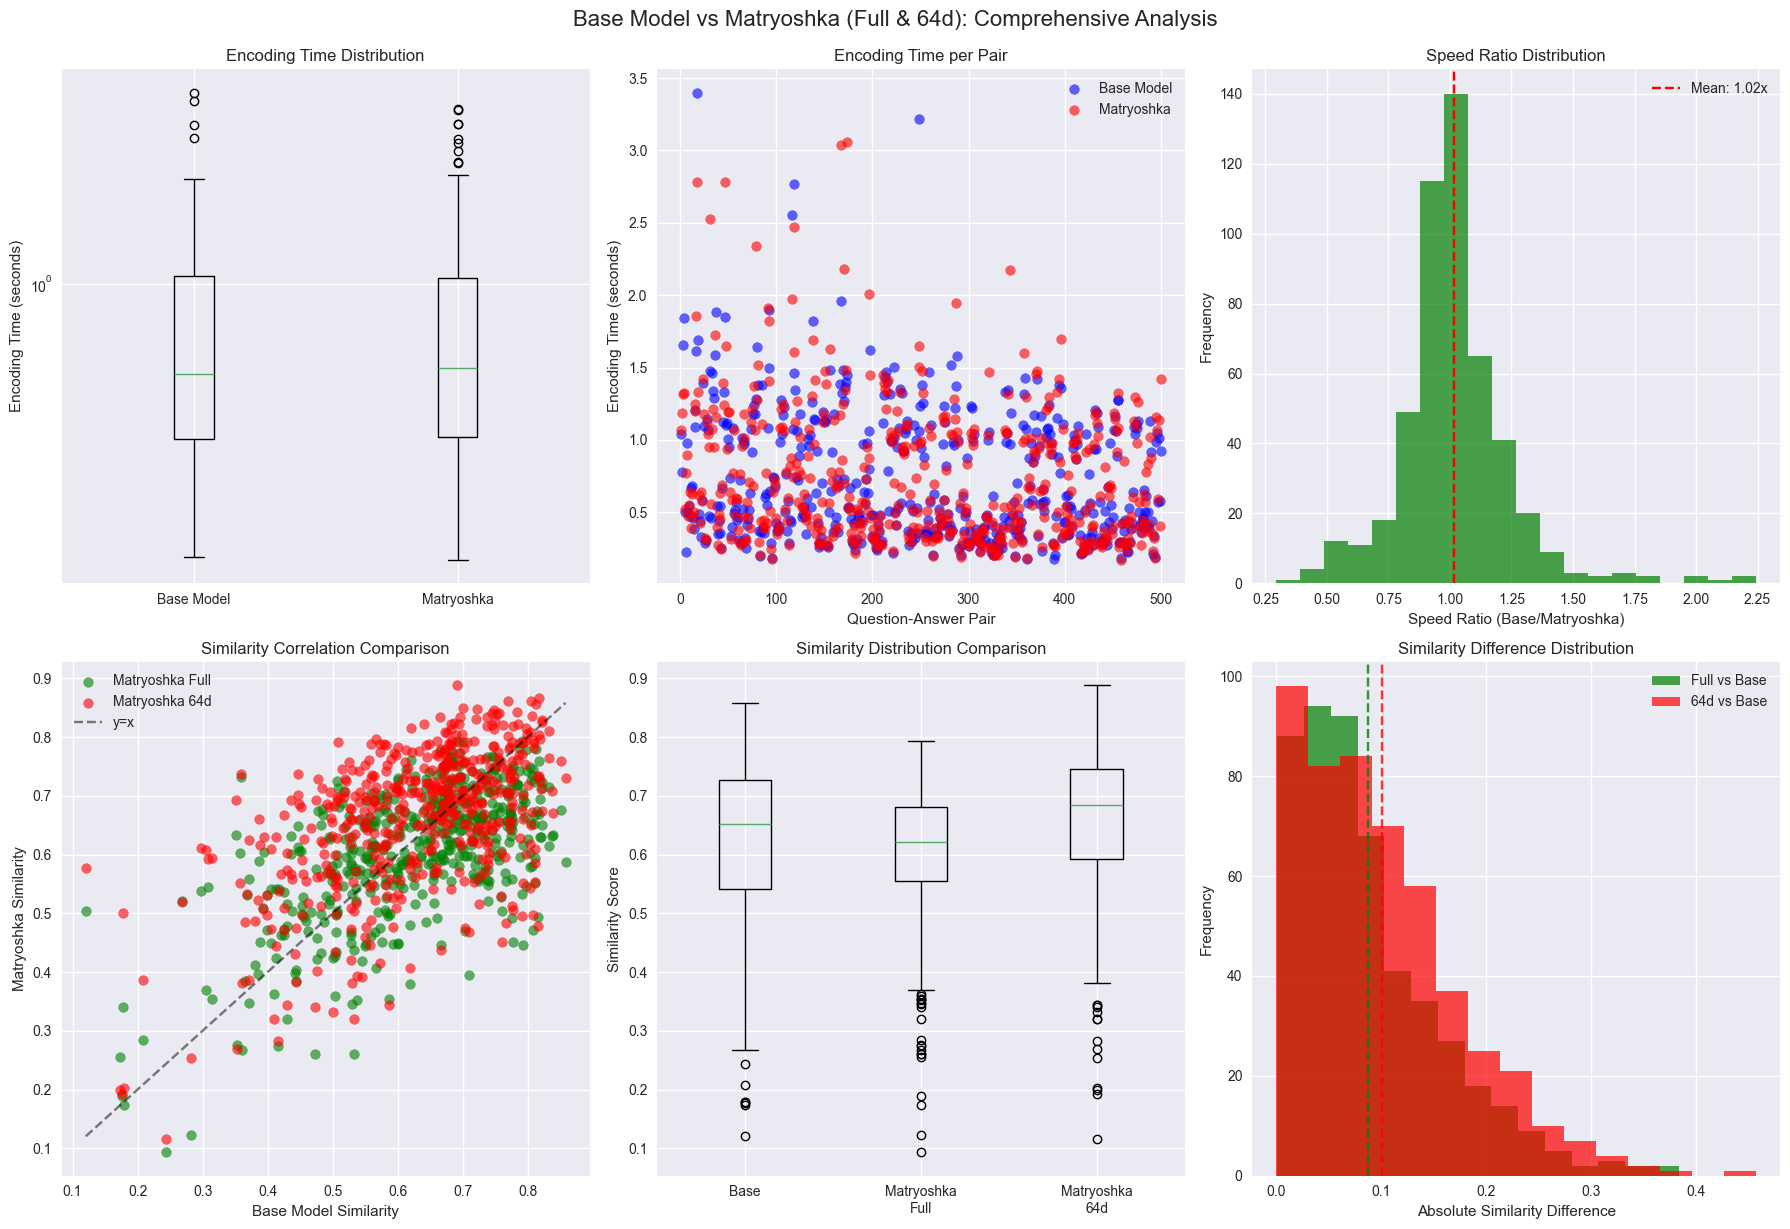


ADDITIONAL PERFORMANCE METRICS (Including Truncated Analysis)
Efficiency (Similarity/Time):
Base Model: 0.86 similarity points per second
Matryoshka Full: 0.82 similarity points per second
Matryoshka 64d: 0.89 similarity points per second
Efficiency ratio (Full): 0.95x
Efficiency ratio (64d): 1.04x

Timing Consistency (lower std = more consistent):
Base Model std: 0.450633 seconds
Matryoshka std: 0.472934 seconds

Correlation Analysis:
Base vs Matryoshka Full: 0.6097
Base vs Matryoshka 64d: 0.5477
Correlation preservation: 89.8%

Performance Analysis:
Performance drop (Full Matryoshka): 3.31%
Performance drop (Matryoshka 64d): -5.48%

Memory Analysis:
Original embedding memory: 3072 bytes
Truncated embedding memory: 256 bytes
Memory savings: 91.7%

⚠️ RECOMMENDATION: Matryoshka 64d offers good trade-off with -5.5% performance drop and 91.7% memory savings


In [57]:
# Visualize timing and similarity comparisons
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Encoding time comparison (box plot)
axes[0, 0].boxplot([base_encoding_times, matryoshka_encoding_times], 
                   labels=['Base Model', 'Matryoshka'])
axes[0, 0].set_ylabel('Encoding Time (seconds)')
axes[0, 0].set_title('Encoding Time Distribution')
axes[0, 0].set_yscale('log')

# 2. Encoding time scatter plot
pair_indices = range(1, len(base_encoding_times) + 1)
axes[0, 1].scatter(pair_indices, base_encoding_times, alpha=0.6, label='Base Model', color='blue')
axes[0, 1].scatter(pair_indices, matryoshka_encoding_times, alpha=0.6, label='Matryoshka', color='red')
axes[0, 1].set_xlabel('Question-Answer Pair')
axes[0, 1].set_ylabel('Encoding Time (seconds)')
axes[0, 1].set_title('Encoding Time per Pair')
axes[0, 1].legend()

# 3. Speed ratio histogram
speed_ratios = [base_t / matryoshka_t for base_t, matryoshka_t in zip(base_encoding_times, matryoshka_encoding_times)]
axes[0, 2].hist(speed_ratios, bins=20, alpha=0.7, color='green')
axes[0, 2].axvline(np.mean(speed_ratios), color='red', linestyle='--', 
                   label=f'Mean: {np.mean(speed_ratios):.2f}x')
axes[0, 2].set_xlabel('Speed Ratio (Base/Matryoshka)')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Speed Ratio Distribution')
axes[0, 2].legend()

# 4. Three-way similarity comparison
axes[1, 0].scatter(base_similarities, matryoshka_similarities, alpha=0.6, label='Matryoshka Full', color='green')
axes[1, 0].scatter(base_similarities, matryoshka_truncated_similarities, alpha=0.6, label=f'Matryoshka {truncate_dim}d', color='red')
axes[1, 0].plot([min(base_similarities), max(base_similarities)], 
                [min(base_similarities), max(base_similarities)], 'k--', label='y=x', alpha=0.5)
axes[1, 0].set_xlabel('Base Model Similarity')
axes[1, 0].set_ylabel('Matryoshka Similarity')
axes[1, 0].set_title('Similarity Correlation Comparison')
axes[1, 0].legend()

# 5. Similarity comparison box plot
similarity_data = [base_similarities, matryoshka_similarities, matryoshka_truncated_similarities]
axes[1, 1].boxplot(similarity_data, labels=['Base', 'Matryoshka\nFull', f'Matryoshka\n{truncate_dim}d'])
axes[1, 1].set_ylabel('Similarity Score')
axes[1, 1].set_title('Similarity Distribution Comparison')

# 6. Similarity difference analysis
similarity_diffs_full = [abs(base_sim - mat_sim) for base_sim, mat_sim in zip(base_similarities, matryoshka_similarities)]
similarity_diffs_truncated = [abs(base_sim - mat_trunc) for base_sim, mat_trunc in zip(base_similarities, matryoshka_truncated_similarities)]

axes[1, 2].hist(similarity_diffs_full, bins=15, alpha=0.7, label='Full vs Base', color='green')
axes[1, 2].hist(similarity_diffs_truncated, bins=15, alpha=0.7, label=f'{truncate_dim}d vs Base', color='red')
axes[1, 2].axvline(np.mean(similarity_diffs_full), color='green', linestyle='--', alpha=0.8)
axes[1, 2].axvline(np.mean(similarity_diffs_truncated), color='red', linestyle='--', alpha=0.8)
axes[1, 2].set_xlabel('Absolute Similarity Difference')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].set_title('Similarity Difference Distribution')
axes[1, 2].legend()

plt.tight_layout()
plt.suptitle(f'Base Model vs Matryoshka (Full & {truncate_dim}d): Comprehensive Analysis', 
             fontsize=16, y=1.02)
plt.show()

# Print additional statistics with truncated comparisons
print("\n" + "="*70)
print("ADDITIONAL PERFORMANCE METRICS (Including Truncated Analysis)")
print("="*70)

# Efficiency metrics
avg_similarity_per_second_base = avg_base_similarity / avg_base_time
avg_similarity_per_second_matryoshka = avg_matryoshka_similarity / avg_matryoshka_time
avg_similarity_per_second_truncated = avg_matryoshka_truncated_similarity / avg_matryoshka_time

print(f"Efficiency (Similarity/Time):")
print(f"Base Model: {avg_similarity_per_second_base:.2f} similarity points per second")
print(f"Matryoshka Full: {avg_similarity_per_second_matryoshka:.2f} similarity points per second")
print(f"Matryoshka {truncate_dim}d: {avg_similarity_per_second_truncated:.2f} similarity points per second")
print(f"Efficiency ratio (Full): {avg_similarity_per_second_matryoshka/avg_similarity_per_second_base:.2f}x")
print(f"Efficiency ratio ({truncate_dim}d): {avg_similarity_per_second_truncated/avg_similarity_per_second_base:.2f}x")

# Consistency metrics
time_std_base = np.std(base_encoding_times)
time_std_matryoshka = np.std(matryoshka_encoding_times)
print(f"\nTiming Consistency (lower std = more consistent):")
print(f"Base Model std: {time_std_base:.6f} seconds")
print(f"Matryoshka std: {time_std_matryoshka:.6f} seconds")

# Correlation analysis
print(f"\nCorrelation Analysis:")
print(f"Base vs Matryoshka Full: {correlation_full:.4f}")
print(f"Base vs Matryoshka {truncate_dim}d: {correlation_truncated:.4f}")
print(f"Correlation preservation: {(correlation_truncated/correlation_full)*100:.1f}%")

# Performance summary with truncation
performance_drop_full = ((avg_base_similarity - avg_matryoshka_similarity) / avg_base_similarity) * 100
performance_drop_truncated = ((avg_base_similarity - avg_matryoshka_truncated_similarity) / avg_base_similarity) * 100

print(f"\nPerformance Analysis:")
print(f"Performance drop (Full Matryoshka): {performance_drop_full:.2f}%")
print(f"Performance drop (Matryoshka {truncate_dim}d): {performance_drop_truncated:.2f}%")

# Memory analysis
original_memory = len(matryoshka_question_embedding) * 4  # 4 bytes per float32
truncated_memory = truncate_dim * 4
memory_savings = ((original_memory - truncated_memory) / original_memory) * 100

print(f"\nMemory Analysis:")
print(f"Original embedding memory: {original_memory} bytes")
print(f"Truncated embedding memory: {truncated_memory} bytes") 
print(f"Memory savings: {memory_savings:.1f}%")

# Final recommendation
if avg_matryoshka_time < avg_base_time and performance_drop_truncated < 5:
    print(f"\n✅ RECOMMENDATION: Matryoshka {truncate_dim}d is {avg_base_time/avg_matryoshka_time:.2f}x faster with only {performance_drop_truncated:.1f}% performance drop!")
elif performance_drop_truncated < 10:
    print(f"\n⚠️ RECOMMENDATION: Matryoshka {truncate_dim}d offers good trade-off with {performance_drop_truncated:.1f}% performance drop and {memory_savings:.1f}% memory savings")
else:
    print(f"\n❌ RECOMMENDATION: {truncate_dim}d truncation causes significant {performance_drop_truncated:.1f}% performance drop")

## Quantization

In [ ]:
# Example query and retrieval
import torch

query = "How Eggs Can Impact Body Odor"
base_query_embedding = base_model.encode(query)
matryoshka_query_embedding = matryoshka_model.encode(query)

base_cos_scores = util.cos_sim(base_query_embedding, base_corpus_embeddings)[0]
matryoshka_cos_scores = util.cos_sim(matryoshka_query_embedding, matryoshka_corpus_embeddings)[0]

# Get the top k results for both models
top_k = 5
top_base_results = torch.topk(base_cos_scores, k=top_k)
top_matryoshka_results = torch.topk(matryoshka_cos_scores, k=top_k)

print(top_base_results.indices)
print(top_matryoshka_results.indices)

print("Base Model Results:")
for idx in top_base_results.indices:
    print(f"Retrieved: {ds_corpus['text'][int(idx)]}")

print("Matryoshka Results:")
for idx in top_matryoshka_results.indices:
    print(f"Retrieved: {ds_corpus['text'][int(idx)]}")

tensor([3389, 1547,  169, 2278, 2675])
tensor([ 686,  169, 3389,  840,  532])
Base Model Results:
Retrieved: Axillary body odor is individually specific and potentially a rich source of information about its producer. Odor individuality partly results from genetic individuality, but the influence of ecological factors such as eating habits are another main source of odor variability. However, we know very little about how particular dietary components shape our body odor. Here we tested the effect of red meat consumption on body odor attractiveness. We used a balanced within-subject experimental design. Seventeen male odor donors were on "meat" or "nonmeat" diet for 2 weeks wearing axillary pads to collect body odor during the final 24 h of the diet. Fresh odor samples were assessed for their pleasantness, attractiveness, masculinity, and intensity by 30 women not using hormonal contraceptives. We repeated the same procedure a month later with the same odor donors, each on the opposite

In [ ]:
# Test multiple queries and compare results between base and matryoshka models
import random
query_indices = random.sample(range(len(ds_query)), 5)
queries = [ds_query[i]["text"] for i in query_indices]

for query in queries:
    print("\nQuery:", query)
    base_query_embedding = base_model.encode(query)
    matryoshka_query_embedding = matryoshka_model.encode(query)

    base_cos_scores = util.cos_sim(base_query_embedding, base_corpus_embeddings)[0]
    matryoshka_cos_scores = util.cos_sim(matryoshka_query_embedding, matryoshka_corpus_embeddings)[0]
    
    base_sentence = ds_corpus["text"][base_cos_scores.argmax().item()]
    matryoshka_sentence = ds_corpus["text"][matryoshka_cos_scores.argmax().item()]

    print("Retrieved (Base):", base_sentence)
    print("Similarity Score (Base):", base_cos_scores[base_cos_scores.argmax().item()].item())
    print("Retrieved (Matryoshka):", matryoshka_sentence)
    print("Similarity Score (Matryoshka):", matryoshka_cos_scores[matryoshka_cos_scores.argmax().item()].item())



Query: Germany
Retrieved (Base): BACKGROUND: There are an estimated one million completed suicides per year worldwide. As a response to increasing concern about suicide within Europe, the EUROSAVE (European Review of Suicide and Violence Epidemiology) study was undertaken to examine recent trends in the epidemiology of suicide and self-inflicted injury mortality in the European Union (EU). METHODS: Suicide and self-inflicted injury mortality data for the 15 EU countries for the years 1984-1998 were obtained from the World Health Organisation (WHO), the European Statistical Office of the European Commission (EUROSTAT) and national statistical agencies. Data were also obtained for a second group of deaths classified as 'undetermined' or 'other violence'. Age-standardized mortality rates were calculated and examined for trends over time. RESULTS: Finland had the highest suicide rate, while Greece had the lowest for the latest available year (1997). Age-standardized suicide rates tended t

## Testing Matryoshka Models

In [ ]:
## Simple test of truncating Matryoshka embeddings


from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim

matryoshka_dim = 64
model = SentenceTransformer("tomaarsen/mpnet-base-nli-matryoshka")

embeddings = model.encode([
    "Rachel is an amazing person.",
    "Maria is an incredible person.",
    "Nikhil is a fantastic person.",
    "Rachel is a wonderful person.",
    "Rachel hates carrots.",
    "Rachel hates food."
])

import numpy as np
print('Shape before truncation:', embeddings.shape)
print('Memory size before truncation: %.2f KB' % (embeddings.nbytes / 1024))

similarities = cos_sim(embeddings[0], embeddings[1:])
print(similarities)

embeddings = embeddings[:, :matryoshka_dim]
print('Shape after truncation:', embeddings.shape)
print('Memory size after truncation: %.2f KB' % (embeddings.nbytes / 1024))

similarities = cos_sim(embeddings[0], embeddings[1:])
print(similarities)


c:\Users\HillSeah\Documents\hill priv\vector-db-research\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\HillSeah\Documents\hill priv\vector-db-research\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\HillSeah\.cache\huggingface\hub\models--tomaarsen--mpnet-base-nli-matryoshka. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Develop

Shape before truncation: (6, 768)
Memory size before truncation: 18.00 KB
tensor([[0.7360, 0.4817, 0.9491, 0.2576, 0.3409]])
Shape after truncation: (6, 64)
Memory size after truncation: 1.50 KB
tensor([[0.7534, 0.5863, 0.9524, 0.2467, 0.2536]])


In [2]:
matryoshka_dim = 64
model = SentenceTransformer("tomaarsen/mpnet-base-nli-matryoshka", truncate_dim=matryoshka_dim)

In [3]:
embeddings = model.encode([
    "Rachel is an amazing person.",
    "Maria is an incredible person.",
    "Nikhil is a fantastic person.",
    "Rachel is a wonderful person.",
    "Rachel hates carrots.",
    "Rachel hates food."
])

In [4]:
print('Shape before truncation:', embeddings.shape)
print('Memory size before truncation: %.2f KB' % (embeddings.nbytes / 1024))

similarities = cos_sim(embeddings[0], embeddings[1:])
print(similarities)

embeddings = embeddings[:, :matryoshka_dim]
print('Shape after truncation:', embeddings.shape)
print('Memory size after truncation: %.2f KB' % (embeddings.nbytes / 1024))

similarities = cos_sim(embeddings[0], embeddings[1:])
print(similarities)

Shape before truncation: (6, 64)
Memory size before truncation: 1.50 KB
tensor([[0.7534, 0.5863, 0.9524, 0.2467, 0.2536]])
Shape after truncation: (6, 64)
Memory size after truncation: 1.50 KB
tensor([[0.7534, 0.5863, 0.9524, 0.2467, 0.2536]])
